<a id='top'></a><a name='top'></a>
# Chapter 4: Finding meaning in word counts (semantic analysis)

## 4.1 From word counts to topic scores

* [Introduction](#introduction)
* [4.0 Imports and Setup](#4.0)
* [4.1 From word counts to topic scores](#4.1)
     - [4.1.1 TF-IDF vectors and lemmatization](#4.1.1)
     - [4.1.2 Topic vectors](#4.1.2)
     - [4.1.3 Thought experiment](#4.1.3)
     - [4.1.4 An algorithm for scoring topics](#4.1.4)
     - [4.1.5 An LDA classifier](#4.1.5)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets

* sms-spam.csv: [script](#sms-spam.csv), [src](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/sms-spam.csv)
* pointcloud.csv.gz: [script](#pointcloud.csv.gz), [src](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/pointcloud.csv.gz)

### Explore

* Analyzing semantics (meaning) to create topic vectors
* Semantic search using the similarity between topic vectors
* Scalable semantic analysis and semantic search for large copora
* Using semantic components (topics) as features in your NLP pipeline
* Navigating high-dimensional vector spaces


### Key points

* You can use SVD for semantic analysis to decompose and transform TF-IDF
* Use LDiA when you need to compute explainable topic vectors
* No matter how you create your topic vectors, they can be used for semantic search to find documents based on their meaning
* Topic vectors can be used to predict whether a social post is spam or is likely to be "liked"
* We can sidestep the curse of dimensionality to approximate nearest neighbors in a semantic vector space


Latent semantic analysis (LSA) is an algorithm for revealing the meaning of word combinations and computing vectors to represent this meaning.  When you use this tool, not only can you represent the meaning of words as vectors, but you can use them to represent the meaning of entire documents. 

Here we explore these semantic or topic vectors. We use weighted frequency scores from TF-IDF vectors to compute the topic “scores” that make up the dimensions of your topic vectors. We use the correlation of normalized term frequencies with each other to group words together in topics to define the dimensions of your new topic vectors.

These topic vectors will help you do a lot of interesting things. They make it possible to search for documents based on their meaning — semantic search. Most of the time, semantic search returns search results that are much better than keyword search (TF- IDF search). Sometimes semantic search returns documents that are exactly what the user is searching for, even when they can’t think of the right words to put in the query.

And you can use these semantic vectors to identify the words and n-grams that best represent the subject (topic) of a statement, document, or corpus (collection of documents). And with this vector of words and their relative importance, you can provide someone with the most meaningful words for a document — a set of keywords that summarizes its meaning.

---
<a name='4.0'></a><a id='4.0'></a>
# 4.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_04.txt"

In [3]:
%%writefile {req_file}
isort
pugnlp
plyfile
scikit-learn-intelex
scrapy
watermark

Overwriting setup/requirements_04.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
#if IS_COLAB:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
%%writefile setup/chp04_4.1_imports.py
import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from pugnlp.stats import Confusion
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp04_4.1_imports.py


In [7]:
!isort setup/chp04_4.1_imports.py --sl
!cat setup/chp04_4.1_imports.py

import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from pugnlp.stats import Confusion
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from watermark import watermark


In [8]:
import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from pugnlp.stats import Confusion
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from watermark import watermark

/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np
/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a fu

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(42)
np.random.seed(42)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
matplotlib: 3.6.2
pandas    : 1.5.3
seaborn   : 0.12.1
numpy     : 1.23.5



---
<a name='4.1'></a><a id='4.1'></a>
# 4.1 From word counts to topic scores
<a href="#top">[back to top]</a>

Problem: Just counting the frequency of words, and scoring the importance of words in a TF-IDF vector or matrix, is not enough. 

Idea: Score the meanings, topics, that the words are used for.

<a name='4.1.1'></a><a id='4.1.1'></a>
## 4.1.1 TF-IDF vectors and lemmatization
<a href="#top">[back to top]</a>

Problem: Lemmatization in TF-IDF can reduce vocabulary size. However, chunks of text that express similar meaning but use different words will not be "close" to each other in a lemmatized TF-IDF vector space model. Conversely, sometimes lemmatized TF-IDF vectors that are close to each other are not similar in meaning.

Idea: Do semantic searching using the similarity between *topic vectors*.

<a name='4.1.2'></a><a id='4.1.2'></a>
## 4.1.2 Topic vectors
<a href="#top">[back to top]</a>

Problem: Obtain a better estimate of what words in a document semantically signify, and what certain combination of words semantically means in a particular document.

Idea: Enable this vector reasoning via extracting additional information from word statistics. 
This is called "word-topic" vectors when used at the word-level. When used for document meaning vectors, they are called "document-topic vectors". The general term for both is "topic vectors". 

Importance: With "topic vectors", we can cluster and search using semantics. The distances between topic vectors now represents semantic meaning. 

<a name='4.1.3'></a><a id='4.1.3'></a>
## 4.1.3 Thought experiment
<a href="#top">[back to top]</a>

Problem: For learning purposes, manually determine topic vectors. 

Idea: Manually create a 3D topic vector. Convert the TF-IDF vectors of a document into topic vectors, weighing words in terms of how much they contribute semantically to topics. 

Importance: This is a subjective, labor-intensive approach to semantic analysis that relies on human intuition and common sense to break down documents into topics. Ultimately we want an automated, scalable approach that relies on algorithms instead.

In [10]:
topic = {}

tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))

topic['petness'] = (
    .3 * tfidf['cat'] +\
    .3 * tfidf['dog'] +\
    0 * tfidf['apple'] +\
    0 * tfidf['lion'] +\
    .2 * tfidf['NYC'] +\
    .2 * tfidf['love']
)

topic['animalness']  = (
    .1 * tfidf['cat']  +\
    .3 * tfidf['dog'] +\
    0 * tfidf['apple'] +\
    0 * tfidf['lion'] -\
    .2 * tfidf['NYC'] +\
    .2 * tfidf['love']
)

topic['cityness'] = (
   .1 * tfidf['dog'] -\
   .1 * tfidf['apple'] +\
   .5 * tfidf['lion'] +\
   .1 * tfidf['NYC'] -\
   .1 * tfidf['love']
)

print(topic['petness'])
print(topic['animalness'])
print(topic['cityness'])

0.45997895973291136
0.32266347978646426
0.3212036905689928


Next step, decide mathematically which topics and words are connected, and what weights those connections should have. 

In [11]:
word_vector = {}
word_vector['cat'] = .3 * topic['petness'] + .1 * topic['animalness'] + 0 * topic['cityness']

word_vector['dog'] = .3 * topic['petness'] + .1 * topic['animalness'] - .1 * topic['cityness']

word_vector['apple'] = 0 * topic['petness'] - .1 * topic['animalness'] + .2 * topic['cityness']

word_vector['lion'] = 0 * topic['petness'] + .5 * topic['animalness'] - .1 * topic['cityness']

word_vector['NYC'] = -.2 * topic['petness'] + .1 * topic['animalness'] + .5 * topic['cityness']

word_vector['love'] = .2 * topic['petness'] - .1 * topic['animalness'] + .1 * topic['cityness']

for k, v in word_vector.items():
    print(f"{k}\t{v:.4f}")

cat	0.1703
dog	0.1381
apple	0.0320
lion	0.1292
NYC	0.1009
love	0.0918


<a name='4.1.4'></a><a id='4.1.4'></a>
## 4.1.4 An algorithm for scoring topics
<a href="#top">[back to top]</a>

Problem: We need an algorithmic way to determine topic vectors, a transformation from TF-IDF vectors into topic vectors.

Idea: Use the Latent semantic analysis (*LDA*) algorithm to analyze our TF-IDF matrix, gathering words into topics. This technique analyzes relationships between documents and the terms contained within by using SVD to scan unstructured data and find hidden relationships between terms and concepts.

Importance: This concept is based on the notion by J.R. Firth, "You shall know a word by the company it keeps". LSA is mainly used for concept searching and automated document categorization. LSA is often referred to a dimension reduction technique, analogous to PCA.

<a name='4.1.5'></a><a id='4.1.5'></a>
## 4.1.5 An LDA classifier
<a href="#top">[back to top]</a>

Problem: We have use-cases requiring a fast and straightforward algorithm variant of LSA.

Idea: The Linear discriminant analysis (`LDA`) may offer better performance for analyzing document similarity within-corpus

Importance: LDA is one-dimensional and does not require SVA. 

---

API Notes:

* To train a LDA model, find the vector (line) between the two centroids for your binary class. 
* LDA is a supervised algorithm, requiring labels for messages. 
* To do inference with this model, we just need to find out if a new TF-IDF vector is close to the in-class (eg spam) centroid than it is to the out-of-class (non-spam) centroid.

<a id='sms-spam.csv'></a><a name='sms-spam.csv'></a>
### Dataset sms-spam.csv
<a href="#top">[back to top]</a>

Train a LDA model to classify SMS messages as spam or nonspam.
 

In [12]:
data_dir = 'data/data_sms_spam'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_sms_spam = f"{data_dir}/sms-spam.csv"
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/sms-spam.csv
!ls -l {data_sms_spam}

File ‘data/data_sms_spam/sms-spam.csv’ already there; not retrieving.

-rw-r--r--  1 gb  staff  493232 Mar 25 11:17 data/data_sms_spam/sms-spam.csv


In [13]:
!head {data_sms_spam}

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"
5,1,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,0,Even my brother is not like to speak with me. They treat me like aids patent.
7,0,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,1,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hour

In [14]:
# Simplified implementation of LDA in Python
sms_src = pd.read_csv(data_sms_spam, index_col=0)
sms_src.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We have 4837 SMS messages, and 683 of them are labeled with the binary class label "spam."

In [15]:
index = ['sms{}{}'.format(i, '!' * j) for (i, j) in zip(range(len(sms_src)), sms_src.spam)]
print(index[:5])
HR() 

sms = pd.DataFrame(
    sms_src.values, 
    columns=sms_src.columns, 
    index=index
)

sms['spam'] = sms.spam.astype(int)

print(f"Total SMS messages: {sms.shape[0]}")
print(f"SMS spam messages: {sms.spam.sum()}")

['sms0', 'sms1', 'sms2!', 'sms3', 'sms4']
----------------------------------------
Total SMS messages: 4837
SMS spam messages: 638


In [16]:
sms.head()

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."


Next, do tokenization and TF-IDF vector transformation on all these SMS messages.

In [17]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(
    raw_documents=sms.text
).toarray()

In [18]:
messages, words = tfidf_docs.shape
print(f"Messages: {messages}")
print(f"Words: {words}")

Messages: 4837
Words: 9232


In [19]:
check_tfidf_docs = pd.DataFrame(tfidf_docs)

check_tfidf_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Columns: 9232 entries, 0 to 9231
dtypes: float64(9232)
memory usage: 340.7 MB


In [20]:
check_tfidf_docs.isnull().values.any()

False

In [21]:
sms_messages, sms_words = tfidf_docs.shape
print(f"sms_messages: {sms_messages}")
print(f"sms_words: {sms_words}")

sms_messages: 4837
sms_words: 9232


In [22]:
sms.spam.sum()

638

Our model will not have lots of information about the words that indicate whether a message is spam or not. 

Usually a Naive Bayes classifier will not work well when the vocabulary is much larger than the number of labeled examples in the dataset. This is where semantic analysis techniques can help.

Semantic analysis gathers up words with similar semantics (such as spamminess) and uses them all together.

We start with the simplest semantic analysis technique, LDA.

In [23]:
# Use mask to select only the spam rows
mask = sms.spam.astype(bool).values
mask

array([False, False,  True, ..., False, False, False])

In [24]:
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [25]:
spam_centroid.round(4)

array([0.0638, 0.0042, 0.0006, ..., 0.    , 0.    , 0.    ])

In [26]:
ham_centroid.round(4)

array([0.0198, 0.0061, 0.0002, ..., 0.0001, 0.0001, 0.0001])

Subtract one centroid from the other to get the line between them.

In [27]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)
spamminess_score.round(4)

array([-0.0147, -0.0201,  0.0386, ..., -0.0101, -0.0034,  0.004 ])

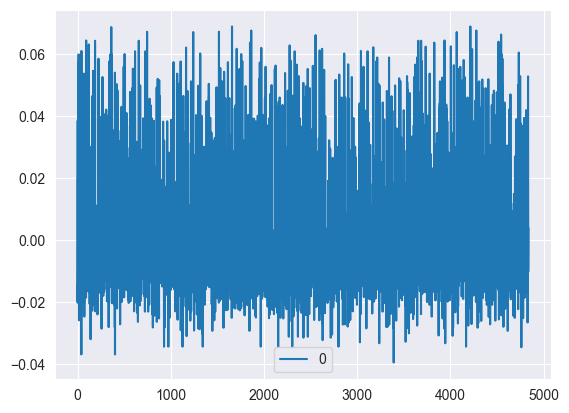

In [28]:
pd.DataFrame(spamminess_score.round(4)).plot();

<a id='pointcloud.csv.gz'></a><a name='pointcloud.csv.gz'></a>
### Dataset pointcloud.csv.gz
<a href="#top">[back to top]</a>

In [29]:
data_dir = 'data/data_pointcloud'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_pointcloud = f'{data_dir}/pointcloud.csv.gz'
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/pointcloud.csv.gz
!ls -l {data_pointcloud}

File ‘data/data_pointcloud/pointcloud.csv.gz’ already there; not retrieving.

-rw-r--r--  1 gb  staff  1285927 Mar 25 11:18 data/data_pointcloud/pointcloud.csv.gz


In [30]:
df = pd.read_csv(data_pointcloud).sample(1000)
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d

,x,y
0,5739.913,-0.010838
1,662.913,0.055300
2,-2943.087,0.017895
3,-1541.087,-0.031069
4,20183.913,-0.018599
...,...,...
995,-10400.087,-0.082136
996,12508.913,-0.070237
997,-10348.087,-0.075675
998,-5425.087,0.104146


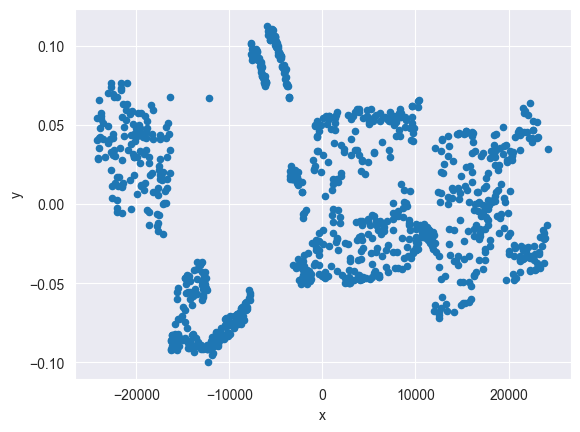

In [31]:
df2d.plot(kind='scatter', x='x', y='y')
plt.show()

We want the score to range between 0 and 1, like a probability.

Use `sklearnMinMaxScaler` for this.

In [32]:
sms['lda_score'] = MinMaxScaler().fit_transform(
    spamminess_score.reshape(-1, 1)
)
sms['lda_predict'] = (sms.lda_score > .5).astype(int)
sms[['spam', 'lda_predict', 'lda_score']].round(2).head(6)

,spam,lda_predict,lda_score
sms0,0,0,0.23
sms1,0,0,0.18
sms2!,1,1,0.72
sms3,0,0,0.18
sms4,0,0,0.29
sms5!,1,1,0.55


In [33]:
# Check the rest of the training set
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

This means 97.7% of the messages were classified correctly with this simple model. 

LDA is a very simple model that should generalize well, as long as the SMS messages are representative of the messages you intend to classify. 

This is power of semantic analysis 

---

Examine the training set confusion matrix. This will show the SMS messages that it labeled as spam that weren't spam at all (false positives), and the ones that were labeled as ham that should have been labeled as spam (false negatives).

In [34]:
'spam lda_predict'.split()

['spam', 'lda_predict']

In [35]:
Confusion(sms[['spam', 'lda_predict']], dtype=object)

lda_predict,0,1
spam,,
0,4135,64
1,45,593


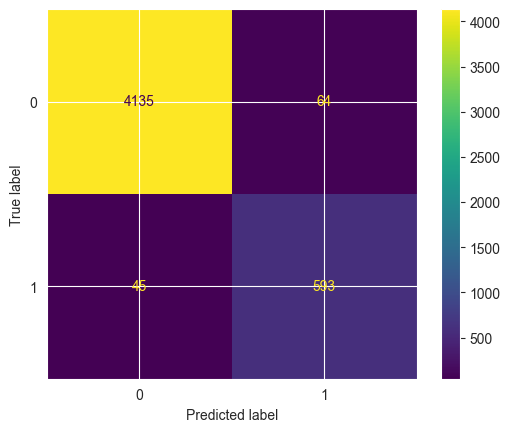

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(sms['spam'], sms['lda_predict'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();